# Preprocessing Notebook

This notebook is used to preprocess the dataset. The preprocessing steps include:

- Loading the dataset
- Filtering the dataset
- Preprocessing the images
- Saving the preprocessed images
- Saving the preprocessed dataset

In [1]:
import torch

from src.utils import show_segmentation_mlo_view
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pydicom

from config import RAW_DATA_DIR, CONVERTED_DATA_DIR, PROCESSED_DATA_DIR

In [3]:
final_df = pd.read_csv(f'{RAW_DATA_DIR}/CMMD/final_df.csv')
metadata_df = pd.read_csv(f'{RAW_DATA_DIR}/CMMD/metadata.csv')

In [4]:
metadata_df.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.1239.1759.623006463861...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0001,1.3.6.1.4.1.14519.5.2.1.1239.1759.335790956129...,NaN,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,.\CMMD\D1-0001\07-18-2010-NA-NA-79377\1.000000...,2022-04-06T19:50:58.958
1,1.3.6.1.4.1.14519.5.2.1.1239.1759.610823649257...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0002,1.3.6.1.4.1.14519.5.2.1.1239.1759.241519791051...,NaN,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,.\CMMD\D1-0002\07-18-2010-NA-NA-49231\1.000000...,2022-04-06T19:50:59.081
2,1.3.6.1.4.1.14519.5.2.1.1239.1759.292560899611...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0003,1.3.6.1.4.1.14519.5.2.1.1239.1759.113089024322...,NaN,07-18-2011,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,.\CMMD\D1-0003\07-18-2011-NA-NA-25491\1.000000...,2022-04-06T19:50:59.25
3,1.3.6.1.4.1.14519.5.2.1.1239.1759.328825651506...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0004,1.3.6.1.4.1.14519.5.2.1.1239.1759.132173027545...,NaN,07-18-2011,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,.\CMMD\D1-0004\07-18-2011-NA-NA-14914\1.000000...,2022-04-06T19:51:00.622
4,1.3.6.1.4.1.14519.5.2.1.1239.1759.148395128205...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,D1-0007,1.3.6.1.4.1.14519.5.2.1.1239.1759.225080655188...,NaN,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,.\CMMD\D1-0007\07-18-2010-NA-NA-58107\1.000000...,2022-04-06T19:51:02.192


In [5]:
metadata_df[metadata_df['Subject ID'] == 'D2-0749'].iloc[0]['File Location']

'.\\CMMD\\D2-0749\\07-17-2012-NA-NA-85032\\1.000000-NA-15082'

In [6]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Series UID            1775 non-null   object 
 1   Collection            1775 non-null   object 
 2   3rd Party Analysis    1775 non-null   object 
 3   Data Description URI  1775 non-null   object 
 4   Subject ID            1775 non-null   object 
 5   Study UID             1775 non-null   object 
 6   Study Description     0 non-null      float64
 7   Study Date            1775 non-null   object 
 8   Series Description    0 non-null      float64
 9   Manufacturer          0 non-null      float64
 10  Modality              1775 non-null   object 
 11  SOP Class Name        1775 non-null   object 
 12  SOP Class UID         1775 non-null   object 
 13  Number of Images      1775 non-null   int64  
 14  File Size             1775 non-null   object 
 15  File Location        

In [7]:
metadata_df.rename(columns={'Subject ID': 'patientId'}, inplace=True)

In [8]:
# Merge dataframes
data_df = pd.merge(left=final_df, right=metadata_df,on='patientId', how='inner')

In [9]:
data_df.head()

,patientId,malignantSide,age,abnormality,classification,subtype,Series UID,Collection,3rd Party Analysis,Data Description URI,...,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,D2-0001,L,64,calcification,Malignant,Luminal B,1.3.6.1.4.1.14519.5.2.1.1239.1759.239900218428...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2011,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,.\CMMD\D2-0001\07-18-2011-NA-NA-75485\1.000000...,2022-04-06T20:02:25.248
1,D2-0002,R,69,calcification,Malignant,Luminal B,1.3.6.1.4.1.14519.5.2.1.1239.1759.215880622311...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,.\CMMD\D2-0002\07-18-2010-NA-NA-26354\1.000000...,2022-04-06T20:02:25.209
2,D2-0003,L,44,calcification,Malignant,Luminal B,1.3.6.1.4.1.14519.5.2.1.1239.1759.126845670317...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,.\CMMD\D2-0003\07-18-2010-NA-NA-57046\1.000000...,2022-04-06T20:02:25.569
3,D2-0004,L,38,calcification,Malignant,Luminal B,1.3.6.1.4.1.14519.5.2.1.1239.1759.247543828374...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,.\CMMD\D2-0004\07-18-2010-NA-NA-29234\1.000000...,2022-04-06T20:02:29.604
4,D2-0005,R,41,calcification,Malignant,HER2-enriched,1.3.6.1.4.1.14519.5.2.1.1239.1759.484289990148...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,.\CMMD\D2-0005\07-18-2010-NA-NA-26051\1.000000...,2022-04-06T20:02:35.752


In [10]:
len(data_df)

674

In [11]:
data_df.query('patientId == "D2-0026"')

,patientId,malignantSide,age,abnormality,classification,subtype,Series UID,Collection,3rd Party Analysis,Data Description URI,...,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
22,D2-0026,L,46,calcification,Malignant,Luminal B,1.3.6.1.4.1.14519.5.2.1.1239.1759.175698785399...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,4,17.57 MB,.\CMMD\D2-0026\07-18-2010-NA-NA-36203\1.000000...,2022-04-06T20:02:50.691


In [12]:
data_df[data_df['Number of Images'] != 4]

,patientId,malignantSide,age,abnormality,classification,subtype,Series UID,Collection,3rd Party Analysis,Data Description URI,...,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
113,D2-0124,L,64,both,Malignant,Luminal B,1.3.6.1.4.1.14519.5.2.1.1239.1759.219713604940...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,.\CMMD\D2-0124\07-18-2010-NA-NA-83231\1.000000...,2022-04-06T20:04:17.26
287,D2-0311,L,45,both,Malignant,HER2-enriched,1.3.6.1.4.1.14519.5.2.1.1239.1759.188818700531...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2011,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,.\CMMD\D2-0311\07-18-2011-NA-NA-32024\1.000000...,2022-04-06T20:07:16.454
372,D2-0402,R,49,mass,Malignant,Luminal A,1.3.6.1.4.1.14519.5.2.1.1239.1759.188719512891...,CMMD,NO,https://doi.org/10.7937/tcia.eqde4b16,...,07-18-2010,NaN,NaN,MG,Digital Mammography X-Ray Image Storage - For ...,1.2.840.10008.5.1.4.1.1.1.2,2,8.79 MB,.\CMMD\D2-0402\07-18-2010-NA-NA-63784\1.000000...,2022-04-06T20:08:42.465


In [13]:
data_df = data_df[['patientId', 'malignantSide', 'age', 'abnormality', 'subtype', 'File Location']]

In [14]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,File Location
0,D2-0001,L,64,calcification,Luminal B,.\CMMD\D2-0001\07-18-2011-NA-NA-75485\1.000000...
1,D2-0002,R,69,calcification,Luminal B,.\CMMD\D2-0002\07-18-2010-NA-NA-26354\1.000000...
2,D2-0003,L,44,calcification,Luminal B,.\CMMD\D2-0003\07-18-2010-NA-NA-57046\1.000000...
3,D2-0004,L,38,calcification,Luminal B,.\CMMD\D2-0004\07-18-2010-NA-NA-29234\1.000000...
4,D2-0005,R,41,calcification,HER2-enriched,.\CMMD\D2-0005\07-18-2010-NA-NA-26051\1.000000...


In [15]:
data_df = data_df.rename(columns={'File Location': 'originalPath'})

In [16]:
data_df['subtype'].value_counts()

subtype
Luminal B          337
Luminal A          141
HER2-enriched      126
triple negative     70
Name: count, dtype: int64

In [17]:
data_df['subtype'] = data_df['subtype'].map({'Luminal B': 'luminal-b', 'Luminal A': 'luminal-a', 'HER2-enriched': 'her2-enriched', 'triple negative': 'triple-negative'})

In [18]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,.\CMMD\D2-0001\07-18-2011-NA-NA-75485\1.000000...
1,D2-0002,R,69,calcification,luminal-b,.\CMMD\D2-0002\07-18-2010-NA-NA-26354\1.000000...
2,D2-0003,L,44,calcification,luminal-b,.\CMMD\D2-0003\07-18-2010-NA-NA-57046\1.000000...
3,D2-0004,L,38,calcification,luminal-b,.\CMMD\D2-0004\07-18-2010-NA-NA-29234\1.000000...
4,D2-0005,R,41,calcification,her2-enriched,.\CMMD\D2-0005\07-18-2010-NA-NA-26051\1.000000...


In [19]:
data_df['originalPath'] = data_df['originalPath'].str.replace(r'\.\\CMMD\\', 'CMMD/', regex=True).str.replace(r'\\', '/', regex=True)

In [20]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,CMMD/D2-0001/07-18-2011-NA-NA-75485/1.000000-N...
1,D2-0002,R,69,calcification,luminal-b,CMMD/D2-0002/07-18-2010-NA-NA-26354/1.000000-N...
2,D2-0003,L,44,calcification,luminal-b,CMMD/D2-0003/07-18-2010-NA-NA-57046/1.000000-N...
3,D2-0004,L,38,calcification,luminal-b,CMMD/D2-0004/07-18-2010-NA-NA-29234/1.000000-N...
4,D2-0005,R,41,calcification,her2-enriched,CMMD/D2-0005/07-18-2010-NA-NA-26051/1.000000-N...


In [21]:
data_df['originalPath'] = data_df['originalPath'].str.replace('CMMD/', '../data/raw/CMMD/CMMD/')

In [22]:
data_df.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0001/07-18-2011-NA-NA...
1,D2-0002,R,69,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0002/07-18-2010-NA-NA...
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0003/07-18-2010-NA-NA...
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0004/07-18-2010-NA-NA...
4,D2-0005,R,41,calcification,her2-enriched,../data/raw/CMMD/CMMD/D2-0005/07-18-2010-NA-NA...


In [23]:
data_df['patientId'].value_counts()

patientId
D2-0706    2
D2-0565    2
D2-0001    1
D2-0497    1
D2-0488    1
          ..
D2-0244    1
D2-0245    1
D2-0246    1
D2-0247    1
D2-0749    1
Name: count, Length: 672, dtype: int64

In [24]:
# Set views and laterality for additional images

data_df_11 = data_df.copy()
data_df_11['originalPath'] = data_df_11['originalPath'] + '/1-1.dcm'
data_df_11 = data_df_11[data_df_11['originalPath'].apply(os.path.exists)]
data_df_11['view'] = 'CC'

data_df_12 = data_df.copy()
data_df_12['originalPath'] = data_df_12['originalPath'] + '/1-2.dcm'
data_df_12 = data_df_12[data_df_12['originalPath'].apply(os.path.exists)]
data_df_12['view'] = 'MLO'

data_df_13 = data_df.copy()
data_df_13['originalPath'] = data_df_13['originalPath'] + '/1-3.dcm'
data_df_13 = data_df_13[data_df_13['originalPath'].apply(os.path.exists)]
data_df_13['view'] = 'CC'

data_df_14 = data_df.copy()
data_df_14['originalPath'] = data_df_14['originalPath'] + '/1-4.dcm'
data_df_14 = data_df_14[data_df_14['originalPath'].apply(os.path.exists)]
data_df_14['view'] = 'MLO'

cmmd = pd.concat([data_df_11, data_df_12, data_df_13, data_df_14])

In [25]:
cmmd.query('patientId == "D2-0565"')

,patientId,malignantSide,age,abnormality,subtype,originalPath,view
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO


In [26]:
# Fix laterality and view
for i, row in cmmd.iterrows():
    if '1-3.dcm' in row['originalPath']:
        patientID = row['patientId']
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-1.dcm')), 'laterality'] = 'L'
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-2.dcm')), 'laterality'] = 'L'
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-1.dcm')), 'view'] = 'CC'
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-2.dcm')), 'view'] = 'MLO'
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-3.dcm')), 'laterality'] = 'R'
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-3.dcm')), 'view'] = 'CC'
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-4.dcm')), 'laterality'] = 'R'
        cmmd.loc[(cmmd['patientId'] == patientID) & (cmmd['originalPath'].str.contains('1-4.dcm')), 'view'] = 'MLO'

In [27]:
cmmd[cmmd['laterality'].isnull()]

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
113,D2-0124,L,64,both,luminal-b,../data/raw/CMMD/CMMD/D2-0124/07-18-2010-NA-NA...,CC,NaN
287,D2-0311,L,45,both,her2-enriched,../data/raw/CMMD/CMMD/D2-0311/07-18-2011-NA-NA...,CC,NaN
372,D2-0402,R,49,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0402/07-18-2010-NA-NA...,CC,NaN
113,D2-0124,L,64,both,luminal-b,../data/raw/CMMD/CMMD/D2-0124/07-18-2010-NA-NA...,MLO,NaN
287,D2-0311,L,45,both,her2-enriched,../data/raw/CMMD/CMMD/D2-0311/07-18-2011-NA-NA...,MLO,NaN
372,D2-0402,R,49,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0402/07-18-2010-NA-NA...,MLO,NaN


In [28]:
cmmd['laterality'] = cmmd['laterality'].fillna(cmmd['malignantSide'])

In [29]:
cmmd.shape

(2690, 8)

In [30]:
cmmd.query('patientId == "D2-0565"')

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC,L
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC,L
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO,L
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO,L
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC,R
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC,R
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO,R
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO,R


In [31]:
cmmd_filtered = cmmd[cmmd['laterality'] == cmmd['malignantSide']]

In [32]:
patient = cmmd_filtered.query('patientId == "D2-0565"')
patient

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC,L
509,D2-0565,L,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO,L
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,CC,R
510,D2-0565,R,75,mass,luminal-a,../data/raw/CMMD/CMMD/D2-0565/07-18-2011-NA-NA...,MLO,R


In [33]:
cmmd_filtered

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0001/07-18-2011-NA-NA...,CC,L
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0003/07-18-2010-NA-NA...,CC,L
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0004/07-18-2010-NA-NA...,CC,L
10,D2-0012,L,32,calcification,her2-enriched,../data/raw/CMMD/CMMD/D2-0012/07-18-2010-NA-NA...,CC,L
11,D2-0013,L,57,calcification,triple-negative,../data/raw/CMMD/CMMD/D2-0013/07-18-2010-NA-NA...,CC,L
...,...,...,...,...,...,...,...,...
667,D2-0740,R,53,mass,luminal-b,../data/raw/CMMD/CMMD/D2-0740/07-18-2011-NA-NA...,MLO,R
668,D2-0741,R,42,mass,her2-enriched,../data/raw/CMMD/CMMD/D2-0741/07-18-2011-NA-NA...,MLO,R
669,D2-0743,R,39,mass,luminal-b,../data/raw/CMMD/CMMD/D2-0743/07-18-2011-NA-NA...,MLO,R
671,D2-0746,R,59,mass,her2-enriched,../data/raw/CMMD/CMMD/D2-0746/07-18-2011-NA-NA...,MLO,R


In [34]:
dcm = pydicom.dcmread(patient.iloc[0]['originalPath'])
dcm.ImageLaterality

'L'

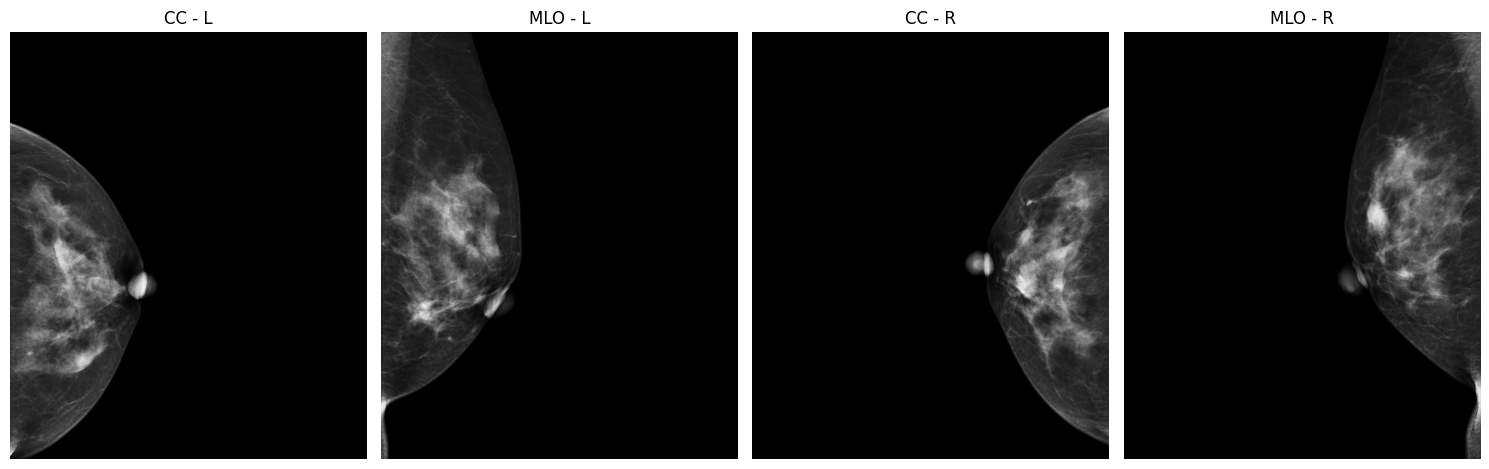

In [35]:
example_patient = cmmd_filtered.query('patientId == "D2-0706"')
# subplot for each view
fig, axs = plt.subplots(1, 4, figsize=(15, 15))
index = 0
for i, row in example_patient.iterrows():
    dcm = pydicom.dcmread(row['originalPath'])
    axs[index].imshow(dcm.pixel_array, cmap='gray')
    axs[index].set_title(f'{row["view"]} - {row["laterality"]}')
    axs[index].axis('off')
    index += 1
plt.tight_layout()
plt.show()

# 2. Preprocessing Pipeline and functions

In [123]:
from src.preprocessing import smart_crop, median_filter, normalize, apply_clahe, histogram_standarization, preprocess_and_persist

## 2.1 Crop Image ROI

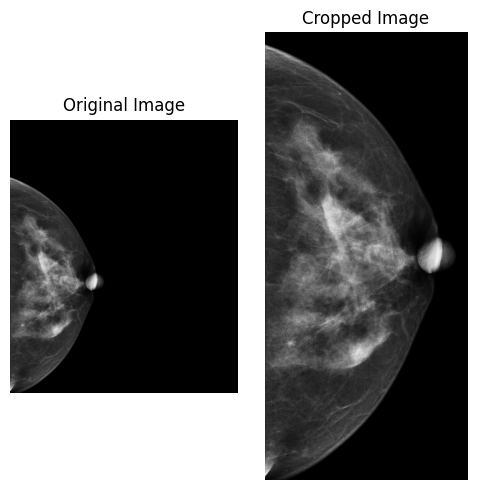

In [37]:
dcm = pydicom.dcmread(example_patient.iloc[0]['originalPath'])
img = dcm.pixel_array
cropped_img = smart_crop(image=img, additional_margin=50)

fig, axs = plt.subplots(1, 2, figsize=(5, 5),)
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(cropped_img, cmap='gray')
axs[1].set_title('Cropped Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 2.2 Median Filter and Normalization

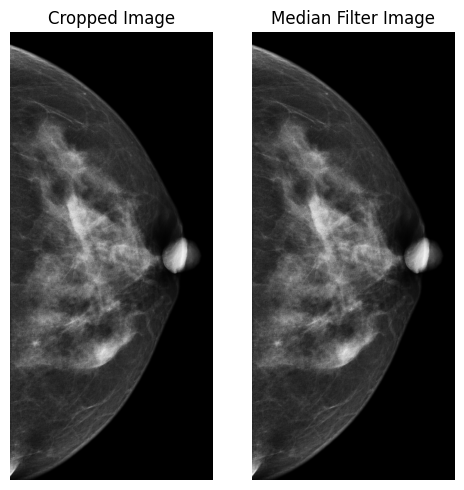

In [38]:
median_img = median_filter(cropped_img, kernel_size=1)

fig, axs = plt.subplots(1, 2, figsize=(5, 5),)
axs[0].imshow(cropped_img, cmap='gray')
axs[0].set_title('Cropped Image')
axs[0].axis('off')

axs[1].imshow(median_img, cmap='gray')
axs[1].set_title('Median Filter Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

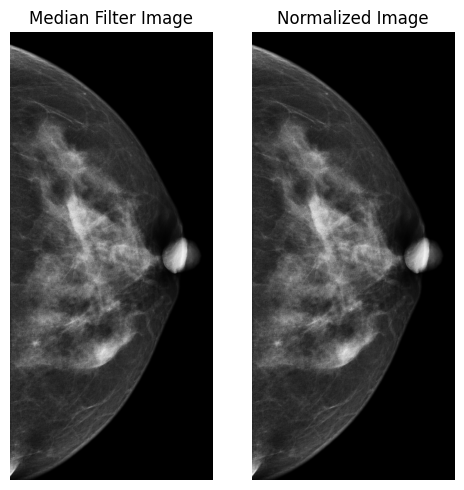

In [39]:
normalized_img = normalize(median_img)

fig, axs = plt.subplots(1, 2, figsize=(5, 5),)
axs[0].imshow(median_img, cmap='gray')
axs[0].set_title('Median Filter Image')
axs[0].axis('off')

axs[1].imshow(normalized_img, cmap='gray')
axs[1].set_title('Normalized Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 2.3 Apply CLAHE

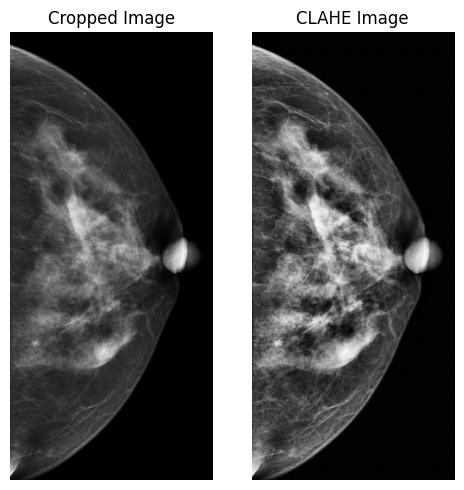

In [65]:
clahe_img = apply_clahe(normalized_img)

fig, axs = plt.subplots(1, 2, figsize=(5, 5),)
axs[0].imshow(cropped_img, cmap='gray')
axs[0].set_title('Cropped Image')
axs[0].axis('off')

axs[1].imshow(clahe_img, cmap='gray')
axs[1].set_title('CLAHE Image')
axs[1].axis('off')

plt.tight_layout()

plt.show()

# 3. Preprocess all images

In [41]:
cmmd_converted = cmmd_filtered.copy()
cmmd_converted['convertedPath'] = ''

In [142]:
# First we preprocess and persist images to before we apply histogram standardization, to train the histogram standardization

cmmd_converted_not_standarized = preprocess_and_persist(cmmd_converted)

Processed 1348 images


In [143]:
cmmd_converted_not_standarized.head()

,patientId,malignantSide,age,abnormality,subtype,originalPath,view,laterality,convertedPath
0,D2-0001,L,64,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0001/07-18-2011-NA-NA...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...
2,D2-0003,L,44,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0003/07-18-2010-NA-NA...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...
3,D2-0004,L,38,calcification,luminal-b,../data/raw/CMMD/CMMD/D2-0004/07-18-2010-NA-NA...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...
10,D2-0012,L,32,calcification,her2-enriched,../data/raw/CMMD/CMMD/D2-0012/07-18-2010-NA-NA...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...
11,D2-0013,L,57,calcification,triple-negative,../data/raw/CMMD/CMMD/D2-0013/07-18-2010-NA-NA...,CC,L,/Users/dacxjo/TFG/data/processed/converted/D2-...


# Histogram Standarization

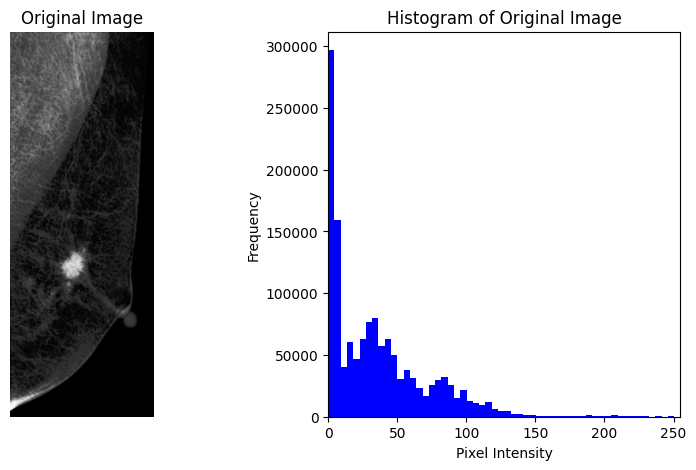

In [158]:
image_0 = cv2.imread(cmmd_converted_not_standarized[cmmd_converted_not_standarized['patientId'] == 'D2-0565'].convertedPath.values[1], cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_0, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].hist(image_0.ravel(), bins=56, color='blue')
axs[1].set_title('Histogram of Original Image')
axs[1].set_xlabel('Pixel Intensity')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim([0, 255])
plt.show()


In [145]:
import torchio as tio
import numpy as np

## Train Histogram Standardization

In [146]:
all_images_paths = cmmd_converted_not_standarized.convertedPath.unique()

if not os.path.exists('landmarks.npy'):
    landmarks = tio.transforms.HistogramStandardization.train(all_images_paths)
    np.save('landmarks.npy', landmarks)


In [147]:
landmarks = np.load('landmarks.npy')

In [148]:
standarized_img = histogram_standarization(image_0, landmarks)

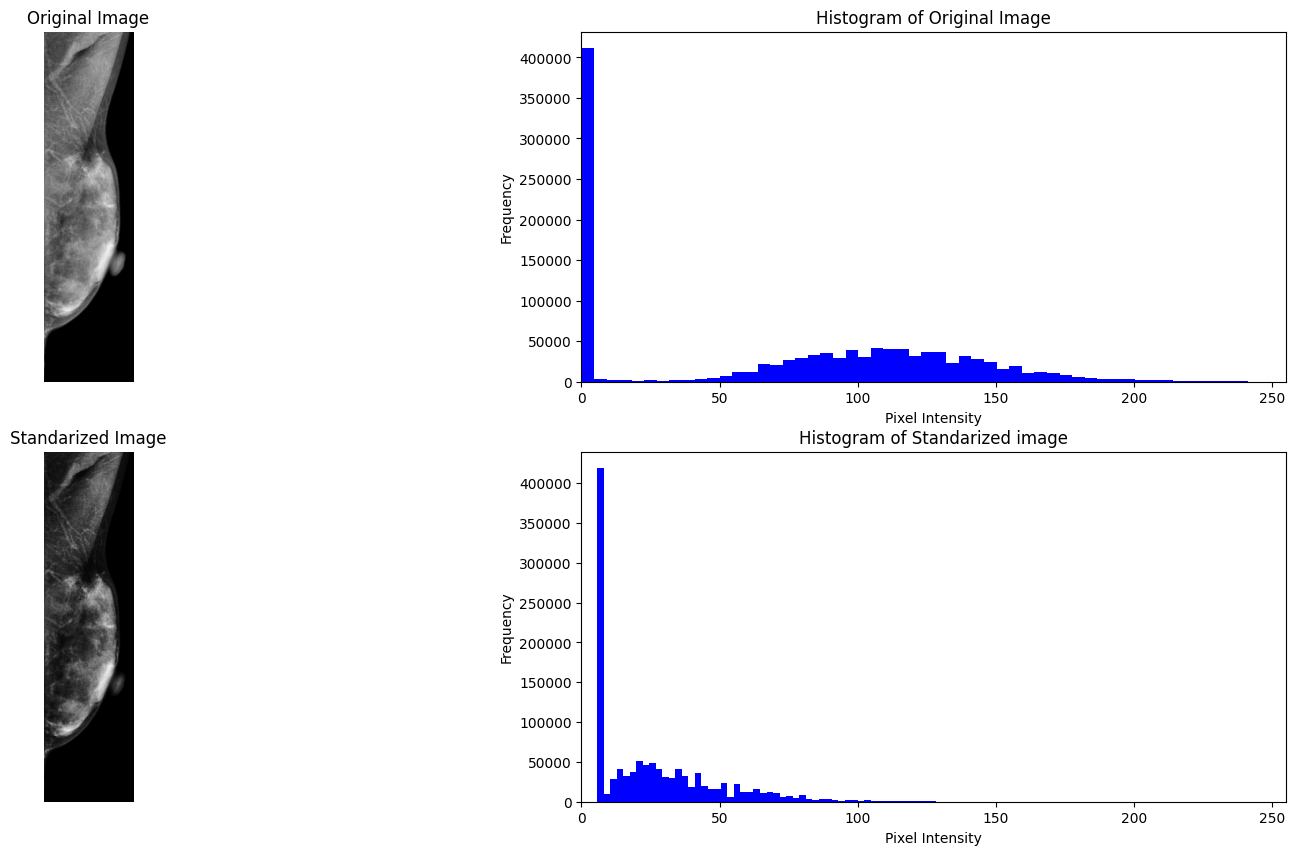

In [156]:
fig, (axs1,axs2) = plt.subplots(2, 2, figsize=(20, 10))


axs1[0].imshow(image_0, cmap='gray')
axs1[0].set_title('Original Image')
axs1[0].axis('off')

axs1[1].hist(image_0.ravel(), bins=56, color='blue')
axs1[1].set_title('Histogram of Original Image')
axs1[1].set_xlabel('Pixel Intensity')
axs1[1].set_ylabel('Frequency')
axs1[1].set_xlim([0, 255])

axs2[0].imshow(standarized_img, cmap='gray')
axs2[0].set_title('Standarized Image')
axs2[0].axis('off')

axs2[1].hist(standarized_img.ravel(), bins=56, color='blue')
axs2[1].set_title('Histogram of Standarized image')
axs2[1].set_xlabel('Pixel Intensity')
axs2[1].set_ylabel('Frequency')
axs2[1].set_xlim([0, 255])
plt.show()


In [150]:
# Now we can apply histogram standardization to all images
cmmd_converted = preprocess_and_persist(cmmd_converted, standarization_landmarks=landmarks)

Processed 1348 images


In [157]:
cmmd_converted.to_csv(f'{CONVERTED_DATA_DIR}/cmmd_converted.csv', index=False)